# The main algorithm for regression in PEST is the Gauss-Levenberg-Marquardt (GLM)  algorithm



In [1]:
%matplotlib inline
import os, sys, shutil
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import zipfile
plt.rcParams['font.size']=10
import response_surface as resurf
# flag to decide if run everything or just visualize results
run_all_flag = False

copy the model files over

In [2]:
import freyberg_setup
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR
# note - switching out with the balanced PST file
pst_name=pst_name.replace('.pst','.r3.pst')
freyberg_setup.setup_pest_kr()


changing model workspace...
   freyberg_kr
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_response_surface_GLM/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/11 10:52:58

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:s

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
noptmax: 0
noptmax: 8


In [3]:
if not run_all_flag:
    shutil.copy2(os.path.join('..','freyberg_k_and_r_response_surface','sweep.zip'),
                 os.path.join(working_dir,'sweep.zip'))
    with zipfile.ZipFile(os.path.join(working_dir,'sweep.zip')) as inzip:
        inzip.extractall(working_dir)
        shutil.move(os.path.join(working_dir, pst_name.replace('.r3.pst','.pst')),
                   os.path.join(working_dir,pst_name))

## Let's open up the `PST` file and check out the parameters

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [5]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


## We need to fix `porosity`, release `rch_0`, and  and put reasonable bounds on the other parameters

In [6]:
par = inpst.parameter_data
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12
par.loc['porosity', 'partrans']='fixed'
par.loc['rch_0', 'partrans']='log'

inpst.write(os.path.join(working_dir,pst_name))
inpst.parameter_data


noptmax: 8


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


## run the response surface function

In [7]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

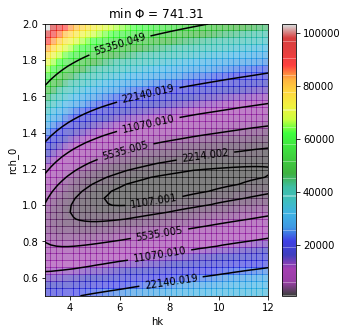

In [8]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

## Let's evaluate the impact of Lambda on regression (regularization included)

In [9]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# turn off the Maquardt lambda
inpst.pestpp_options['lambdas']=0.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk', 'parval1'] = 10.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.95
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'

In [10]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,10.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.95,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [11]:
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.nolam.pst')))

noptmax: 250


In [12]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.nolam.pst'), 
                           num_slaves=7, master_dir='.')
os.chdir("..")


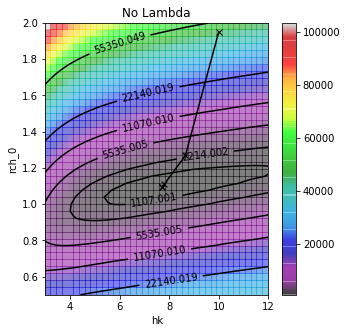

In [13]:
fig, ax = resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'nolam','No Lambda', working_dir, pst_name, ['hk','rch_0'])

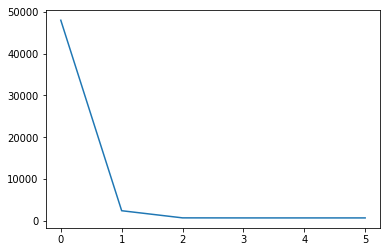

In [14]:
obfun.total_phi.plot()

# Let's try a moderate value `(7000.0)` for Lambda

In [15]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# set the Maquardt lambda to 100.0
inpst.pestpp_options['lambdas']=7000.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk', 'parval1'] = 10.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.95
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam7000.0.pst')))


noptmax: 250


In [16]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam7000.0.pst'), 
                           num_slaves=7, master_dir='.')
os.chdir("..")

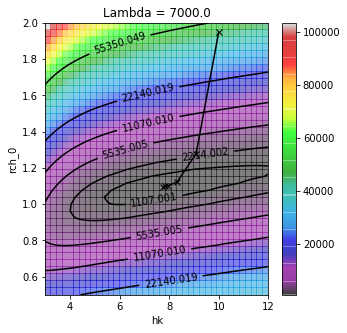

In [17]:
fig, ax = resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam7000.0','Lambda = 7000.0', working_dir, pst_name, ['hk','rch_0'])


### OK - so we have curved a bit toward the steepest descent direction.

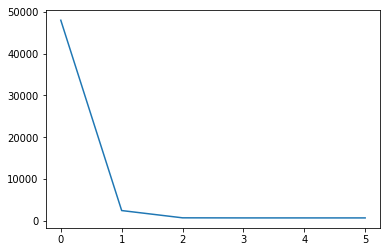

In [18]:
obfun.total_phi.plot()

# Let's try a really big value value `(500000.0)` for Lambda

In [19]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam500000.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=500000.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk', 'parval1'] = 10.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.95
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.phiredstp=0.000001
inpst.control_data.relparstp=0.000001
inpst.control_data.nphistp=6
inpst.control_data.nrelpar=6
inpst.control_data.noptmax=550
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam500000.0.pst')))

noptmax: 550


In [20]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam500000.0.pst'), 
                           num_slaves=7, master_dir='.')
os.chdir("..")

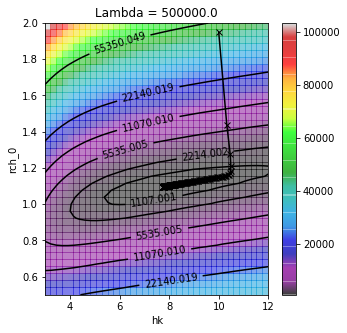

In [21]:
fig, ax = resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam500000.0','Lambda = 500000.0', working_dir, pst_name, ['hk','rch_0'])


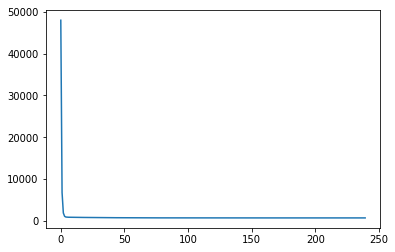

In [22]:
obfun.total_phi.plot()

In [23]:
pars.tail()

,iteration,hk,porosity,rch_0,rch_1
235,235,7.74571,0.01,1.09668,1
236,236,7.74531,0.01,1.09667,1
237,237,7.74492,0.01,1.09666,1
238,238,7.74454,0.01,1.09664,1
239,239,7.74416,0.01,1.09663,1


In [24]:
obfun.tail()

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,calflux,calhead,flaqx,flout,flx_constan,...,forecast,pothead,vol_constan,vol_in-out,vol_percent,vol_recharg,vol_storage,vol_stream_,vol_total,vol_wells
235,235,1166,728.469,728.469,0,0.0841,728.385,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,236,1171,728.469,728.469,0,0.0841,728.385,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,237,1176,728.468,728.468,0,0.0841,728.384,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238,238,1181,728.469,728.469,0,0.0841,728.385,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,239,1186,728.469,728.469,0,0.0841,728.385,0,0,0,...,0,0,0,0,0,0,0,0,0,0
